In [ ]:
# Google Colab Real-time Mask Detection for MOBILENETV2

# Run this in Google Colab to use your webcam for mask detection

# ============================================
# CELL 1: Install and Import Dependencies
# ============================================

# Install required packages (run this first)
!pip install opencv-python-headless
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import io
from PIL import Image
import time

# ============================================
# CELL 2: Upload Your Trained Model
# ============================================

from google.colab import files

# Upload your mask_detector_model.h5 file
print("📁 Please upload your mask_detector_model.h5 file:")
uploaded = files.upload()

# Get the uploaded filename
model_filename = list(uploaded.keys())[0]
print(f"✅ Model uploaded: {model_filename}")

# ============================================
# CELL 3: Mask Detection Class
# ============================================

class ColabMaskDetector:
    def __init__(self, model_path):
        """
        Initialize the mask detector for Google Colab
        """
        try:
            # Load the trained model
            self.model = load_model(model_path)
            print(f"✅ Model loaded successfully from {model_path}")

            # Test model input shape
            input_shape = self.model.input_shape
            print(f"📊 Model input shape: {input_shape}")

        except Exception as e:
            print(f"❌ Error loading model: {e}")
            return

        # Load face cascade classifier
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # Labels (matching your training)
        self.labels = ['Without Mask', 'With Mask']

        # Colors for visualization
        self.colors = {
            'Without Mask': (255, 0, 0),    # Red (RGB format for matplotlib)
            'With Mask': (0, 255, 0)        # Green
        }

        # Model input size (160x160 based on your training)
        self.img_size = 160

    def preprocess_face(self, face):
        """
        Preprocess face for prediction (matching your training preprocessing)
        """
        # Resize to model input size
        face = cv2.resize(face, (self.img_size, self.img_size))

        # Convert BGR to RGB (matching training)
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

        # Normalize (matching training: data.astype("float32") / 255.0)
        face = face.astype("float32") / 255.0

        # Add batch dimension
        face = np.expand_dims(face, axis=0)

        return face

    def predict_mask(self, face):
        """
        Predict mask presence
        """
        processed_face = self.preprocess_face(face)
        prediction = self.model.predict(processed_face, verbose=0)[0]
        class_idx = np.argmax(prediction)
        confidence = prediction[class_idx]
        return self.labels[class_idx], confidence

    def detect_faces_and_masks(self, image):
        """
        Detect faces and predict masks in a single image
        """
        # Convert RGB to BGR for OpenCV processing
        bgr_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = self.face_cascade.detectMultiScale(
            gray, scaleFactor=1.1, minNeighbors=4,
            minSize=(60, 60), flags=cv2.CASCADE_SCALE_IMAGE
        )

        results = []
        annotated_image = image.copy()

        for (x, y, w, h) in faces:
            # Extract face
            face = bgr_image[y:y+h, x:x+w]

            if face.size > 0:
                try:
                    # Predict mask
                    label, confidence = self.predict_mask(face)

                    # Store result
                    results.append({
                        'bbox': (x, y, w, h),
                        'label': label,
                        'confidence': confidence
                    })

                    # Draw bounding box on image
                    color = self.colors[label]

                    # Draw rectangle
                    cv2.rectangle(annotated_image, (x, y), (x+w, y+h),
                                color[::-1], 3)  # Convert RGB to BGR

                    # Add text
                    text = f"{label}: {confidence*100:.1f}%"
                    cv2.putText(annotated_image, text, (x, y-10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.7, color[::-1], 2)

                except Exception as e:
                    print(f"Error processing face: {e}")

        return annotated_image, results

# ============================================
# CELL 4: Initialize Detector
# ============================================

# Initialize the detector
detector = ColabMaskDetector(model_filename)

# ============================================
# CELL 5: Webcam Capture Functions
# ============================================

def take_photo(filename='photo.jpg', quality=0.8):
    """
    Take a photo using the webcam in Colab
    """
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Capture Photo';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))

    # Convert base64 to image
    binary = b64decode(data.split(',')[1])
    f = io.BytesIO(binary)
    return Image.open(f)

def start_continuous_detection():
    """
    Start continuous webcam detection (captures every few seconds)
    """
    print("🎥 Starting continuous mask detection...")
    print("📋 Instructions:")
    print("- Click 'Capture Photo' when prompted")
    print("- Position your face clearly in the camera")
    print("- Run the next cell to stop detection")

    # Take and process photos
    for i in range(10):  # Take 10 photos
        print(f"\n📸 Capture #{i+1}/10")
        try:
            # Capture photo
            img = take_photo(quality=0.7)

            # Convert PIL to numpy array
            img_array = np.array(img)

            # Detect masks
            annotated_img, results = detector.detect_faces_and_masks(img_array)

            # Display results
            plt.figure(figsize=(10, 8))
            plt.imshow(annotated_img)
            plt.axis('off')
            plt.title(f'Mask Detection Results - Capture {i+1}', fontsize=16)

            # Print detection summary
            if results:
                print(f"✅ Detected {len(results)} face(s):")
                for j, result in enumerate(results):
                    status = "✓ SAFE" if result['label'] == "With Mask" else "⚠ NO MASK"
                    print(f"   Face {j+1}: {result['label']} ({result['confidence']*100:.1f}%) {status}")
            else:
                print("❌ No faces detected")

            plt.show()

        except Exception as e:
            print(f"❌ Error in capture {i+1}: {e}")
            continue

# ============================================
# CELL 6: Single Photo Detection
# ============================================
# CELL 6: Upload Image Detection (Updated)
# ============================================

def upload_photo_detection():
    """
    Upload an image from your computer and detect masks
    """
    print("📁 Please upload an image file (JPG/PNG)...")
    from google.colab import files
    uploaded = files.upload()

    try:
        # Get uploaded image file
        image_filename = list(uploaded.keys())[0]
        img = Image.open(image_filename).convert('RGB')
        img_array = np.array(img)

        # Detect masks
        annotated_img, results = detector.detect_faces_and_masks(img_array)

        # Display results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Original image
        ax1.imshow(img_array)
        ax1.set_title('Original Image', fontsize=14)
        ax1.axis('off')

        # Annotated image
        ax2.imshow(annotated_img)
        ax2.set_title('Mask Detection Results', fontsize=14)
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        # Print detailed results
        print("\n" + "="*50)
        print("🔍 DETECTION SUMMARY")
        print("="*50)

        if results:
            print(f"👥 Total faces detected: {len(results)}")
            for i, result in enumerate(results):
                x, y, w, h = result['bbox']
                label = result['label']
                confidence = result['confidence']
                status = "✅ SAFE" if label == "With Mask" else "⚠️ WARNING"

                print(f"\n🔹 Face {i+1}:")
                print(f"   Location: ({x}, {y}) - {w}x{h} pixels")
                print(f"   Prediction: {label}")
                print(f"   Confidence: {confidence*100:.1f}%")
                print(f"   Status: {status}")
        else:
            print("❌ No faces detected in the image")
            print("💡 Tips:")
            print("   - Ensure good lighting")
            print("   - Use a clear image with visible faces")

    except Exception as e:
        print(f"❌ Error processing uploaded image: {e}")


# ============================================
# CELL 7: Usage Instructions
# ============================================

print("🚀 Google Colab Mask Detection System Ready!")
print("="*60)
print("📱 System Configuration:")
print(f"   - Model: {model_filename}")
print("   - Input Size: 160x160 pixels")
print("   - Classes: With Mask, Without Mask")
print("="*60)
print("\n🎯 How to use:")
print("1. Run: single_photo_detection() - for one photo")
print("2. Run: start_continuous_detection() - for multiple photos")
print("\n💡 Example usage:")
print("   single_photo_detection()")
print("   # or")
print("   start_continuous_detection()")
print("="*60)

# ============================================
# READY TO USE - Call these functions:
# ============================================

# Uncomment the line below to start single photo detection
# single_photo_detection()

# Uncomment the line below to start continuous detection
# start_continuous_detection()

📁 Please upload your mask_detector_model.h5 file:


Saving mask_detector_model.h5 to mask_detector_model.h5
✅ Model uploaded: mask_detector_model.h5


✅ Model loaded successfully from mask_detector_model.h5
📊 Model input shape: (None, 160, 160, 3)
🚀 Google Colab Mask Detection System Ready!
📱 System Configuration:
   - Model: mask_detector_model.h5
   - Input Size: 160x160 pixels
   - Classes: With Mask, Without Mask

🎯 How to use:
1. Run: single_photo_detection() - for one photo
2. Run: start_continuous_detection() - for multiple photos

💡 Example usage:
   single_photo_detection()
   # or
   start_continuous_detection()


📸 Single Photo Mask Detection
Click 'Capture Photo' when ready...


<IPython.core.display.Javascript object>

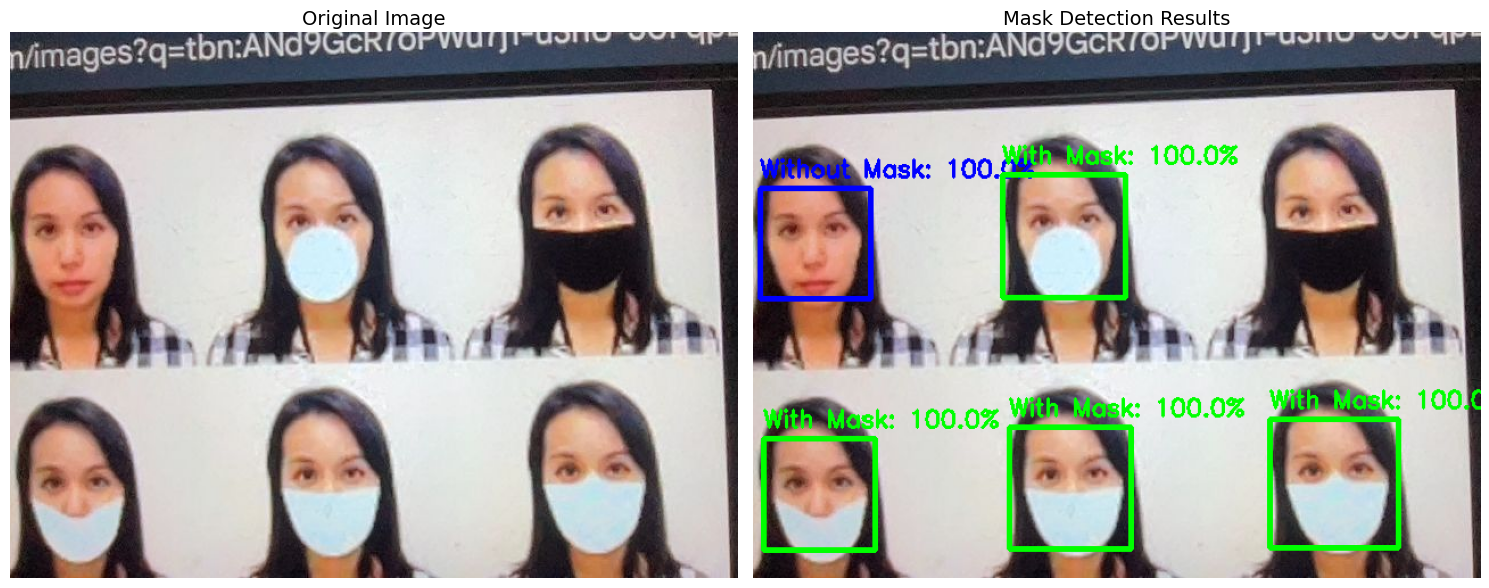


🔍 DETECTION SUMMARY
👥 Total faces detected: 5

🔹 Face 1:
   Location: (6, 137) - 97x97 pixels
   Prediction: Without Mask
   Confidence: 100.0%
   Status: ⚠️ WARNING

🔹 Face 2:
   Location: (219, 125) - 108x108 pixels
   Prediction: With Mask
   Confidence: 100.0%
   Status: ✅ SAFE

🔹 Face 3:
   Location: (454, 340) - 113x113 pixels
   Prediction: With Mask
   Confidence: 100.0%
   Status: ✅ SAFE

🔹 Face 4:
   Location: (225, 347) - 107x107 pixels
   Prediction: With Mask
   Confidence: 100.0%
   Status: ✅ SAFE

🔹 Face 5:
   Location: (9, 357) - 98x98 pixels
   Prediction: With Mask
   Confidence: 100.0%
   Status: ✅ SAFE


In [ ]:
single_photo_detection()

📁 Please upload an image file (JPG/PNG)...


Saving woman-mask-split-04-ht-jt-210316_1615932165011_hpEmbed_4x3_992.jpg to woman-mask-split-04-ht-jt-210316_1615932165011_hpEmbed_4x3_992.jpg


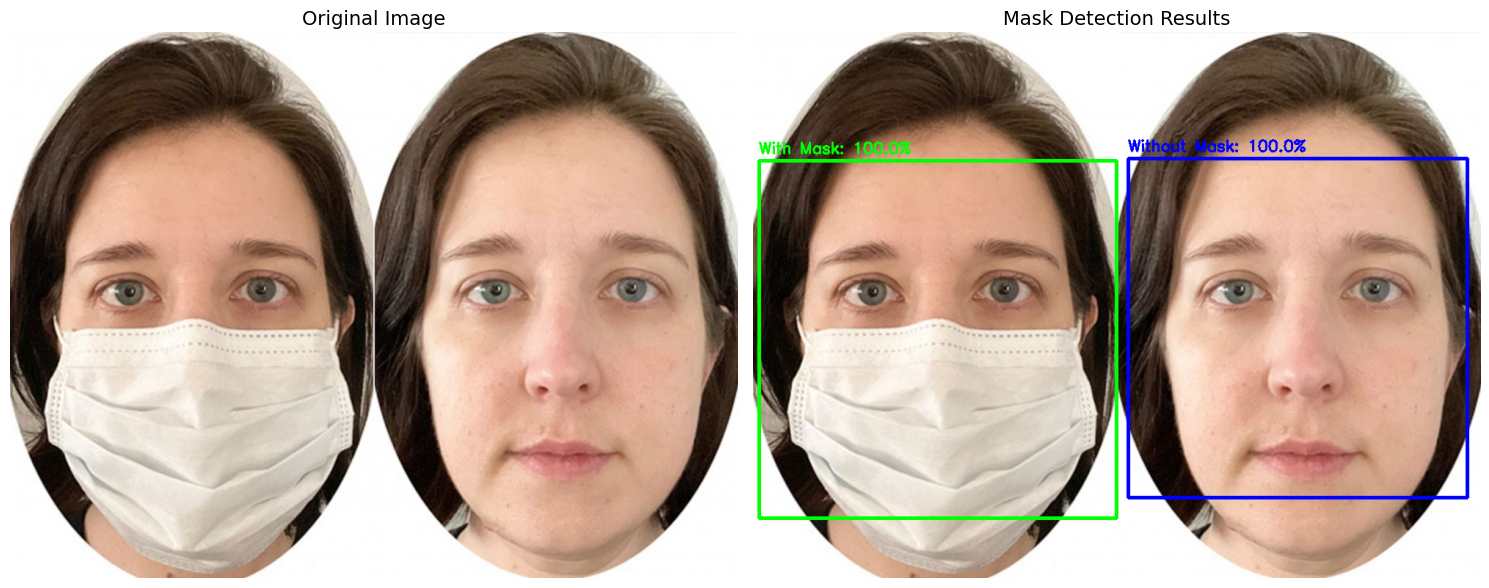


🔍 DETECTION SUMMARY
👥 Total faces detected: 2

🔹 Face 1:
   Location: (511, 172) - 462x462 pixels
   Prediction: Without Mask
   Confidence: 100.0%
   Status: ⚠️ WARNING

🔹 Face 2:
   Location: (8, 175) - 487x487 pixels
   Prediction: With Mask
   Confidence: 100.0%
   Status: ✅ SAFE


In [ ]:
upload_photo_detection()
